<a href="https://colab.research.google.com/github/PhanChenh/Optimizing_Sentiment_Models_NLPproject/blob/main/Optimizing_Sentiment_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title: Optimizing Sentiment Analysis Models for Accurate Predictions

## Project Objectives:
Evaluate and compare the performance of various word embeddings and seq2seq models for sentiment analysis. The aim is to identify the best-performing models and configurations for analyzing customer sentiment.

## Project structure:
Outline the models and embeddings being tested: GloVe, Word2Vec (CBOW and Skipgram), FastText (CBOW and Skipgram), and Seq2Seq models (LSTM with different configurations), as well as the RNN and GRU models in the ablation study

Text Preprocessing & Data Preparation:
- Clean the review data by removing noise such as special characters, stop words, and any irrelevant information to prepare the text for analysis.

Word Embeddings:
- GloVe: Description of the GloVe word embeddings and how they are utilized in the model.
- Word2Vec (CBOW and Skipgram): Explanation of the Continuous Bag of Words (CBOW) and Skipgram models, highlighting their differences and how they represent word relationships.
- FastText (CBOW and Skipgram): Introduction to FastText, its ability to represent out-of-vocabulary words, and how it improves upon Word2Vec.

Seq2Seq Models:
- LSTM with Different Location Aspect: Description of the LSTM architecture, focusing on the addition of location-based aspects.
- LSTM with Attention: Explanation of the attention mechanism in LSTM to focus on relevant parts of the sequence while making predictions.
- LSTM with Double Attention: Introduce the concept of double attention, where attention mechanisms are applied at both the word and sentence levels to improve sentiment understanding.

Ablation Study:
- RNN Model: A basic Recurrent Neural Network model to establish a baseline for comparison.
- GRU Model: Description of the GRU model and how it differs from LSTM, focusing on its simpler architecture and potential efficiency in training.

If you run into the error indicates that torch (PyTorch) is not available for your Python version or platform through pip. Please run the code in google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models import FastText
from nltk.corpus import stopwords
import json
import re
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocessing

In this section, preprocessing will be done. Given test, validation and test dataset, the test and validation dataset will be combined into one big train dataset which will be used to predict the test dataset.

In [ ]:
## read dataset - connect to google drive account

train = open("drive/MyDrive/nlp_data/train.json")
val = open("drive/MyDrive/nlp_data/val.json")
test = open("drive/MyDrive/nlp_data/test.json")


In [ ]:
train_data = json.load(train)
val_data = json.load(val)
test_data = json.load(test)

In [ ]:
len(val_data["data"]) + len(train_data["data"])+len(test_data["data"])

8879

In [ ]:
## we will only use train and test dataset. Therefore, validation dataset will be combined with training dataset


### Training
train_reviews = []
train_aspects = []
train_label = []
for i in train_data["data"]:
  train_reviews.append(i[0])
  train_aspects.append(i[1])
  train_label.append(i[2])

for i in val_data["data"]:
  train_reviews.append(i[0])
  train_aspects.append(i[1])
  train_label.append(i[2])


### Testing
test_reviews = []
test_aspects = []
test_label = []
for i in test_data["data"]:
  test_reviews.append(i[0])
  test_aspects.append(i[1])
  test_label.append(i[2])


In [ ]:
eda_train_aspect = {}
for i in train_data["data"]:
    aspect = str(i[1])+"_"+str(i[2])
    if aspect not in eda_train_aspect:
        eda_train_aspect[aspect] = 1
    else:
        eda_train_aspect[aspect] += 1

eda_val_aspect = {}
for i in val_data["data"]:
    aspect = str(i[1])+"_"+str(i[2])
    if aspect not in eda_val_aspect:
        eda_val_aspect[aspect] = 1
    else:
        eda_val_aspect[aspect] += 1

eda_test_aspect = {}
for i in test_data["data"]:
    aspect = str(i[1])+"_"+str(i[2])
    if aspect not in eda_test_aspect:
        eda_test_aspect[aspect] = 1
    else:
        eda_test_aspect[aspect] += 1


In [ ]:
print("----------------------")
print("Train")
print("----------------------")
for i in eda_train_aspect:
  print(i + " = " + str(eda_train_aspect[i]))

print("----------------------")
print("Val")
print("----------------------")
for i in eda_val_aspect:
  print(i + " = " + str(eda_val_aspect[i]))

print("----------------------")
print("Test")
print("----------------------")
for i in eda_test_aspect:
  print(i + " = " + str(eda_test_aspect[i]))

----------------------
Train
----------------------
food_positive = 754
place_neutral = 430
staff_positive = 332
miscellaneous_neutral = 531
staff_negative = 922
service_negative = 329
miscellaneous_negative = 196
food_neutral = 1298
price_positive = 72
miscellaneous_positive = 227
food_negative = 255
menu_positive = 64
place_positive = 125
ambience_neutral = 53
service_neutral = 128
menu_neutral = 372
ambience_negative = 90
service_positive = 174
price_negative = 114
place_negative = 139
ambience_positive = 181
price_neutral = 136
staff_neutral = 129
menu_negative = 39
----------------------
Val
----------------------
miscellaneous_neutral = 73
food_positive = 88
staff_negative = 119
food_neutral = 180
service_negative = 39
service_neutral = 20
food_negative = 22
menu_neutral = 41
place_neutral = 42
staff_positive = 34
price_neutral = 17
menu_negative = 3
staff_neutral = 12
service_positive = 25
place_positive = 25
ambience_positive = 21
price_negative = 20
miscellaneous_negative = 23

The cleaning process for each dataset will be done in the following chunk of codes. At first, all contradiction words will be replaced and followed by puctuation and digits removal. After that, each sentence input will be tokenized.

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def cleaning_process(data):
  stop_words = set(stopwords.words('english'))
  output = []
  for sent in data:
      token_sent = []
      sent = sent.lower() #case-folding
      for word, new_word in contraction_dict.items():
          sent = sent.replace(word, new_word) #dealing with contractions
      sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
      sent = re.sub(r"\d", '', sent) ##removing digit
      for word in sent.split():
          if word not in stop_words and word != '':
            token_sent.append(word)
      output.append(token_sent)

  return output


train_reviews = cleaning_process(train_reviews)
test_reviews = cleaning_process(test_reviews)
## no need to clean for aspect as its already in lower case


## create list of words
words = set([])
for s in train_reviews:
    for w in s:
        words.add(w.lower())


for s in test_reviews:
    for w in s:
        words.add(w.lower())

for w in train_aspects:
    words.add(w.lower())


As all the input sentences need to have the same length, maximum padding need to be find out first.

In [ ]:
## Find out the max embedding

def word_counter(sentences):
  max_words = 0
  for sentence in sentences:
      max_words = max(max_words, len(sentence))
  return max_words

print("Maximum number of words in train data:", word_counter(train_reviews))
print("Maximum number of words in test data:", word_counter(test_reviews))
### 67 embedding is the result

Maximum number of words in train data: 40
Maximum number of words in test data: 28


In [ ]:
max_length = 40

Now, We also need to encode the label to be one hot.

In [ ]:
## Label output
sentiment_mapping = {'positive': [1, 0, 0],
                     'neutral': [0, 1, 0],
                     'negative': [0, 0, 1]}

label_train_torch = torch.tensor( [sentiment_mapping[sentiment] for sentiment in train_label], dtype=torch.float32)
label_test_torch = torch.tensor([sentiment_mapping[sentiment] for sentiment in test_label], dtype=torch.float32)

We will try to create 5 different inputs for the ablation study, which are word embedding from Glove, Word2vec Cbow, Word2Vec Skipgram, FastText Cbow, and FastText skipgram.

## GLOVE

For glove embedding, we will use the pre trained word embedding embedding of wikipedia words that has 50 dimension from glove.

In [ ]:
embeddings_index = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
stemmer = SnowballStemmer("english") ## initialized stemmer

In [ ]:
### Each words will be stemeed to find out the original root of the word first before putting it into glove vectors.
### All the unknown words will be represented by the mean of all the vectors in the sentences.
def text_embed_glove(words, glove_embedding, max_length):

    unknown_indices = []
    result = np.zeros(50*max_length).reshape((max_length,50))
    mean = np.zeros(50)

    for i in range(len(words)):
        root = stemmer.stem(words[i])
        if root != "":

          if root in glove_embedding:

              result[i] = glove_embedding[root]
              mean += result[i]
          else:
              unknown_indices.append(i)
        else:
          unknown_indices.append(i)
    mean /= len(words)-len(unknown_indices)

    # unknown words in the text are represented using the mean of the known words
    for i in unknown_indices:
        result[i] = mean

    return np.array(result)


In [ ]:
train_review_embed, test_review_embed = [],[]
for i in train_reviews:
  sentence_embed = text_embed_glove(i, embeddings_index,max_length)
  train_review_embed.append(sentence_embed)

for i in test_reviews:
  sentence_embed = text_embed_glove(i, embeddings_index,max_length)
  test_review_embed.append(sentence_embed)


train_aspect_embed, test_aspect_embed = [],[]
for i in train_aspects:
  train_aspect_embed.append([embeddings_index[i]])

for i in test_aspects:
  test_aspect_embed.append([embeddings_index[i]])


In [ ]:
train_rev_torch = torch.tensor(np.array(train_review_embed),  dtype=torch.float32)
test_rev_torch = torch.tensor(np.array(test_review_embed),  dtype=torch.float32)
train_asp_torch = torch.tensor(np.array(train_aspect_embed), dtype=torch.float32)
test_asp_torch = torch.tensor(np.array(test_aspect_embed), dtype=torch.float32)

In [ ]:
# train_rev_torch has size ==  torch.Size([7978, 40, 50])
# train_asp_torch has size == torch.Size([7978, 1, 50])

# use torch.cat to combine them into [7978, 41, 50]
final_train_glove = torch.cat((train_rev_torch, train_asp_torch), dim=1)
final_test_glove = torch.cat((test_rev_torch, test_asp_torch), dim=1)

final_train_glove.shape

torch.Size([7978, 41, 50])

## Word2Vec Cbow

Firstly, we will need to combine all words in both train and test dataset. Note that we concat reviews and aspect together as there is no "miscellaneous" word presents in the reviews.

In [ ]:
train_rev_asp = [sublist + [train_aspects[i]] for i, sublist in enumerate(train_reviews)]
test_rev_asp = [sublist + [test_aspects[i]] for i, sublist in enumerate(test_reviews)]
all_reviews = train_rev_asp+test_rev_asp
len(all_reviews)

8879

In [ ]:
wv_cbow_model = Word2Vec(all_reviews, vector_size=50, window=5, min_count=5, workers=2, sg=0)

In [ ]:
def text_embed_w2v(words, w2v, max_length):
    unknown_indices = []
    result = np.zeros(50*max_length).reshape((max_length,50))
    mean = np.zeros(50)

    for i in range(len(words)):
      if words[i] in w2v.wv:
          result[i] = w2v.wv[words[i]]
          mean += result[i]
      else:
          unknown_indices.append(i)

    mean /= len(words)-len(unknown_indices)

    # unknown words in the text are represented using the mean of the known words
    for i in unknown_indices:
        result[i] = mean

    return np.array(result)

In [ ]:
train_review_embed, test_review_embed = [],[]
for i in train_reviews:
  sentence_embed = text_embed_w2v(i, wv_cbow_model,max_length)
  train_review_embed.append(sentence_embed)

for i in test_reviews:
  sentence_embed = text_embed_w2v(i, wv_cbow_model,max_length)
  test_review_embed.append(sentence_embed)


train_aspect_embed, test_aspect_embed = [],[]
for i in train_aspects:
  train_aspect_embed.append([wv_cbow_model.wv[i]])

for i in test_aspects:
  test_aspect_embed.append([wv_cbow_model.wv[i]])

In [ ]:
train_rev_torch = torch.tensor(np.array(train_review_embed),  dtype=torch.float32)
test_rev_torch = torch.tensor(np.array(test_review_embed),  dtype=torch.float32)
train_asp_torch = torch.tensor(np.array(train_aspect_embed), dtype=torch.float32)
test_asp_torch = torch.tensor(np.array(test_aspect_embed), dtype=torch.float32)

In [ ]:
final_train_w2v_cbow = torch.cat((train_rev_torch, train_asp_torch), dim=1)
final_test_w2v_cbow = torch.cat((test_rev_torch, test_asp_torch), dim=1)

final_train_w2v_cbow.shape

torch.Size([7978, 41, 50])

## Word2Vec SkipGram

In [ ]:
wv_skipgram_model = Word2Vec(all_reviews, vector_size=50, window=5, min_count=5, workers=2, sg=1)

In [ ]:
train_review_embed, test_review_embed = [],[]
for i in train_reviews:
  sentence_embed = text_embed_w2v(i, wv_skipgram_model,max_length)
  train_review_embed.append(sentence_embed)

for i in test_reviews:
  sentence_embed = text_embed_w2v(i, wv_skipgram_model,max_length)
  test_review_embed.append(sentence_embed)


train_aspect_embed, test_aspect_embed = [],[]
for i in train_aspects:
  train_aspect_embed.append([wv_skipgram_model.wv[i]])

for i in test_aspects:
  test_aspect_embed.append([wv_skipgram_model.wv[i]])

In [ ]:
train_rev_torch = torch.tensor(np.array(train_review_embed),  dtype=torch.float32)
test_rev_torch = torch.tensor(np.array(test_review_embed),  dtype=torch.float32)
train_asp_torch = torch.tensor(np.array(train_aspect_embed), dtype=torch.float32)
test_asp_torch = torch.tensor(np.array(test_aspect_embed), dtype=torch.float32)

In [ ]:
final_train_w2v_skipgram = torch.cat((train_rev_torch, train_asp_torch), dim=1)
final_test_w2v_skipgram = torch.cat((test_rev_torch, test_asp_torch), dim=1)

final_train_w2v_skipgram.shape

torch.Size([7978, 41, 50])

## FastText Cbow

In [ ]:
ft_cb_model = FastText(all_reviews, vector_size=50, window=5, min_count=5, workers=2, sg=0)

In [ ]:
train_review_embed, test_review_embed = [],[]
for i in train_reviews:
  sentence_embed = text_embed_w2v(i, ft_cb_model,max_length)
  train_review_embed.append(sentence_embed)

for i in test_reviews:
  sentence_embed = text_embed_w2v(i, ft_cb_model,max_length)
  test_review_embed.append(sentence_embed)


train_aspect_embed, test_aspect_embed = [],[]
for i in train_aspects:
  train_aspect_embed.append([ft_cb_model.wv[i]])

for i in test_aspects:
  test_aspect_embed.append([ft_cb_model.wv[i]])

In [ ]:
train_rev_torch = torch.tensor(np.array(train_review_embed),  dtype=torch.float32)
test_rev_torch = torch.tensor(np.array(test_review_embed),  dtype=torch.float32)
train_asp_torch = torch.tensor(np.array(train_aspect_embed), dtype=torch.float32)
test_asp_torch = torch.tensor(np.array(test_aspect_embed), dtype=torch.float32)

In [ ]:
final_train_ft_cbow = torch.cat((train_rev_torch, train_asp_torch), dim=1)
final_test_ft_cbow = torch.cat((test_rev_torch, test_asp_torch), dim=1)

final_train_ft_cbow.shape

torch.Size([7978, 41, 50])

## FastText Skipgram

In [ ]:
ft_sk_model = FastText(all_reviews, vector_size=50, window=5, min_count=5, workers=2, sg=1)

In [ ]:
train_review_embed, test_review_embed = [],[]
for i in train_reviews:
  sentence_embed = text_embed_w2v(i, ft_sk_model,max_length)
  train_review_embed.append(sentence_embed)

for i in test_reviews:
  sentence_embed = text_embed_w2v(i, ft_sk_model,max_length)
  test_review_embed.append(sentence_embed)


train_aspect_embed, test_aspect_embed = [],[]
for i in train_aspects:
  train_aspect_embed.append([ft_sk_model.wv[i]])

for i in test_aspects:
  test_aspect_embed.append([ft_sk_model.wv[i]])

In [ ]:
train_rev_torch = torch.tensor(np.array(train_review_embed),  dtype=torch.float32)
test_rev_torch = torch.tensor(np.array(test_review_embed),  dtype=torch.float32)
train_asp_torch = torch.tensor(np.array(train_aspect_embed), dtype=torch.float32)
test_asp_torch = torch.tensor(np.array(test_aspect_embed), dtype=torch.float32)

In [ ]:
final_train_ft_skipgram = torch.cat((train_rev_torch, train_asp_torch), dim=1)
final_test_ft_skipgram = torch.cat((test_rev_torch, test_asp_torch), dim=1)

final_train_ft_skipgram.shape

torch.Size([7978, 41, 50])

# Model 1 - LSTM with different location aspect

In the model 1, the base Model will be LSTM. Furthermore, this section will provide how to put the aspect information in different location.

Why "Different Location Aspect" Matters:

The positioning of the aspect information can influence how well the model learns the relationship between the aspect (e.g., food, service) and the sentiment of the review. For instance:
- If the aspect is placed first, the LSTM might focus more on understanding the aspect's influence throughout the review.
- If the aspect is placed last, the LSTM might focus on how the aspect is influenced by the rest of the review content.

Thus, testing "different locations" of the aspect in the sequence helps evaluate which configuration best improves the model's ability to correlate aspects with sentiment.

Note that our input is the concatenation between reviews and aspects. As the reviews has maximum length of 40 and aspect only has one length, the concatenation between the two of them will be 41.
The Steps are:
1.   Use all the reviews information into the LSTM model
2.   The result or hidden layer from LSTM model will be concated with the last information in the input, which is the aspect information.
3.   Reshape the result of step2 before putting it into linear model
4.   Apply softmax layer to make the result into categorization vectors.


How the "Different Location Aspect" Relates to Your LSTM Model:

- Step 2 (Concatenation): Here, you're concatenating the aspect with the review text (which has been processed by the LSTM). Depending on where the aspect information is placed (before, after, or interleaved), the LSTM will process the input sequence in different ways, affecting how it learns the relationship between the review and aspect.

- Step 3 (Reshaping): After the LSTM processes the concatenated input, the hidden states are reshaped before passing them to the linear layer. This step is important for aligning the hidden states with the expected input format of the classification layer.

- Step 4 (Softmax): The final output of the model will be a softmax layer that converts the model's prediction into probability scores for different sentiment categories (positive, negative, neutral, etc.). How the aspect is positioned in the input sequence might affect the final categorization outcome.



 ***Note: For hyperparameter tunning on ablation study, there will be no additional section. The code can just be re run by uncomment the optimizers**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size,number_padding, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## number_padding : 41
        ## output_size : 3

        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size*number_padding, output_size)



    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq[:, :-1, :]) ## at first only use the review aspect ([7978, 40, 50])

        concat_aspect = torch.cat((lstm_out, input_seq[:,-1:,:]), dim=1) ## now concat with the aspect ([7978, 1, 50])
        fc1_out = self.fc1(concat_aspect.view(concat_aspect.size(0), -1))
        output = F.softmax( fc1_out, dim=1)
        return output

embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
number_padding = final_train_glove.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = LSTMClassifier(embedding_size, hidden_size, number_padding,output_size)


# Define loss function and optimizer - adam & sgd
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001) ### uncomment to try
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
number_padding = final_train_glove.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = LSTMClassifier(embedding_size, hidden_size, number_padding,output_size)


# Define loss function and optimizer - adam & sgd
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001) ### uncomment to try
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Glove-Input

In [ ]:
# Training loop - glove
for epoch in range(1000):  # Training for 1000 epochs
    optimizer.zero_grad()
    output = model(final_train_glove)
    loss = criterion(output, label_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0963
Epoch [101/1000], Loss: 0.9204
Epoch [201/1000], Loss: 0.8139
Epoch [301/1000], Loss: 0.7272
Epoch [401/1000], Loss: 0.6869
Epoch [501/1000], Loss: 0.6684
Epoch [601/1000], Loss: 0.6587
Epoch [701/1000], Loss: 0.6529
Epoch [801/1000], Loss: 0.6497
Epoch [901/1000], Loss: 0.6461


In [ ]:
output = model(final_test_glove)
output = output.detach().numpy()

max_indices = np.argmax(output, axis=1)
predicted_glove = np.zeros_like(output)
predicted_glove[np.arange(len(output)), max_indices] = 1

In [ ]:
num_correct = np.sum(np.all(predicted_glove == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

Number of correct answers: 479


In [ ]:
# Compute confusion matrix
conf_matrix = np.zeros((predicted_glove.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_glove, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1


# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  86                 94                  65
True Neutral                   60                273                  60
True Negative                  56                 87                 120


In [ ]:
accuracy_glove = num_correct/label_test_torch.numpy().shape[0]
accuracy_glove*100

53.163152053274146

In [ ]:
cr = classification_report(label_test_torch.numpy(), predicted_glove, target_names=["Positive", "Neutral", "Negative"])
print(cr)


              precision    recall  f1-score   support

    Positive       0.43      0.35      0.38       245
     Neutral       0.60      0.69      0.64       393
    Negative       0.49      0.46      0.47       263

   micro avg       0.53      0.53      0.53       901
   macro avg       0.51      0.50      0.50       901
weighted avg       0.52      0.53      0.52       901
 samples avg       0.53      0.53      0.53       901



## Word2Vec Cbow-Input

In [ ]:
# Training loop - glove
for epoch in range(1000):  # Training for 1000 epochs
    optimizer.zero_grad()
    output = model(final_train_w2v_cbow)
    loss = criterion(output, label_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))


Epoch [1/1000], Loss: 1.1802
Epoch [101/1000], Loss: 1.1171
Epoch [201/1000], Loss: 1.1171
Epoch [301/1000], Loss: 1.1171
Epoch [401/1000], Loss: 1.1171
Epoch [501/1000], Loss: 1.1171
Epoch [601/1000], Loss: 1.1171
Epoch [701/1000], Loss: 1.1171
Epoch [801/1000], Loss: 1.1171
Epoch [901/1000], Loss: 1.1171


In [ ]:
output = model(final_test_w2v_cbow)
output = output.detach().numpy()

max_indices = np.argmax(output, axis=1)
predicted_w2v_cb = np.zeros_like(output)
predicted_w2v_cb[np.arange(len(output)), max_indices] = 1

In [ ]:
num_correct = np.sum(np.all(predicted_w2v_cb == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

Number of correct answers: 393


In [ ]:
# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_cb.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_cb, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1


# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  99                 94                  52
True Neutral                   66                274                  53
True Negative                  51                103                 109


In [ ]:
accuracy_w2v_cb = num_correct/label_test_torch.numpy().shape[0]
accuracy_w2v_cb*100

43.61820199778024

In [ ]:
cr = classification_report(label_test_torch.numpy(), predicted_w2v_cb, target_names=["Positive", "Neutral", "Negative"])
print(cr)

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00       245
     Neutral       0.44      1.00      0.61       393
    Negative       0.00      0.00      0.00       263

   micro avg       0.44      0.44      0.44       901
   macro avg       0.15      0.33      0.20       901
weighted avg       0.19      0.44      0.26       901
 samples avg       0.44      0.44      0.44       901



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Word2Vec Skipgram-Input

In [ ]:
# Training loop - glove
for epoch in range(1000):  # Training for 1000 epochs
    optimizer.zero_grad()
    output = model(final_train_w2v_skipgram)
    loss = criterion(output, label_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))


Epoch [1/1000], Loss: 1.0901
Epoch [101/1000], Loss: 0.8826
Epoch [201/1000], Loss: 0.8357
Epoch [301/1000], Loss: 0.8097
Epoch [401/1000], Loss: 0.8071
Epoch [501/1000], Loss: 0.8013
Epoch [601/1000], Loss: 0.7685
Epoch [701/1000], Loss: 0.8749
Epoch [801/1000], Loss: 0.8248
Epoch [901/1000], Loss: 0.7995


In [ ]:
output = model(final_test_w2v_skipgram)
output = output.detach().numpy()

max_indices = np.argmax(output, axis=1)
predicted_w2v_sk = np.zeros_like(output)
predicted_w2v_sk[np.arange(len(output)), max_indices] = 1

In [ ]:
num_correct = np.sum(np.all(predicted_w2v_sk == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

Number of correct answers: 520


In [ ]:
# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_sk.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_sk, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1


# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

Confusion matrix:
               Predicted Positive  Predicted Neutral  True Negative
True Positive                 103                 85             57
True Neutral                   53                298             42
True Negative                  54                 90            119


In [ ]:
accuracy_w2v_sk= num_correct/label_test_torch.numpy().shape[0]
accuracy_w2v_sk*100

57.71365149833518

In [ ]:
cr = classification_report(label_test_torch.numpy(), predicted_w2v_sk, target_names=["Positive", "Neutral", "Negative"])
print(cr)

              precision    recall  f1-score   support

    Positive       0.49      0.42      0.45       245
     Neutral       0.63      0.76      0.69       393
    Negative       0.55      0.45      0.49       263

   micro avg       0.58      0.58      0.58       901
   macro avg       0.56      0.54      0.55       901
weighted avg       0.57      0.58      0.57       901
 samples avg       0.58      0.58      0.58       901



## FastText Cbow-Input

In [ ]:
# Training loop - glove
for epoch in range(1000):  # Training for 1000 epochs
    optimizer.zero_grad()
    output = model(final_train_ft_cbow)
    loss = criterion(output, label_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.1005
Epoch [101/1000], Loss: 0.9985
Epoch [201/1000], Loss: 0.9534
Epoch [301/1000], Loss: 0.9061
Epoch [401/1000], Loss: 0.8716
Epoch [501/1000], Loss: 0.8484
Epoch [601/1000], Loss: 0.8253
Epoch [701/1000], Loss: 0.8102
Epoch [801/1000], Loss: 0.8890
Epoch [901/1000], Loss: 0.8296


In [ ]:
output = model(final_test_ft_cbow)
output = output.detach().numpy()

max_indices = np.argmax(output, axis=1)
predicted_ft_cb = np.zeros_like(output)
predicted_ft_cb[np.arange(len(output)), max_indices] = 1

In [ ]:
num_correct = np.sum(np.all(predicted_ft_cb == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

Number of correct answers: 474


In [ ]:
# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_cb.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_cb, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1


# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

Confusion matrix:
               Predicted Positive  Predicted Neutral  True Negative
True Positive                  83                112             50
True Neutral                   51                276             66
True Negative                  47                101            115


In [ ]:
accuracy_ft_cb = num_correct/label_test_torch.numpy().shape[0]
accuracy_ft_cb*100

52.608213096559375

In [ ]:
cr = classification_report(label_test_torch.numpy(), predicted_ft_cb, target_names=["Positive", "Neutral", "Negative"])
print(cr)

              precision    recall  f1-score   support

    Positive       0.46      0.34      0.39       245
     Neutral       0.56      0.70      0.63       393
    Negative       0.50      0.44      0.47       263

   micro avg       0.53      0.53      0.53       901
   macro avg       0.51      0.49      0.49       901
weighted avg       0.52      0.53      0.51       901
 samples avg       0.53      0.53      0.53       901



## FastText Skipgram-Input

In [ ]:
# Training loop - glove
for epoch in range(1000):  # Training for 1000 epochs
    optimizer.zero_grad()
    output = model(final_train_ft_skipgram)
    loss = criterion(output, label_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0398
Epoch [101/1000], Loss: 0.9253
Epoch [201/1000], Loss: 0.9012
Epoch [301/1000], Loss: 0.8836
Epoch [401/1000], Loss: 0.8672
Epoch [501/1000], Loss: 0.8509
Epoch [601/1000], Loss: 0.8347
Epoch [701/1000], Loss: 0.8196
Epoch [801/1000], Loss: 0.8038
Epoch [901/1000], Loss: 0.7905


In [ ]:
output = model(final_test_ft_skipgram)
output = output.detach().numpy()

max_indices = np.argmax(output, axis=1)
predicted_ft_sk = np.zeros_like(output)
predicted_ft_sk[np.arange(len(output)), max_indices] = 1

In [ ]:
num_correct = np.sum(np.all(predicted_ft_sk == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

Number of correct answers: 500


In [ ]:
# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_sk.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_cb, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1


# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

Confusion matrix:
               Predicted Positive  Predicted Neutral  True Negative
True Positive                  83                112             50
True Neutral                   51                276             66
True Negative                  47                101            115


In [ ]:
accuracy_ft_sk = num_correct/label_test_torch.numpy().shape[0]
accuracy_ft_sk*100

55.49389567147613

In [ ]:
cr = classification_report(label_test_torch.numpy(), predicted_ft_sk, target_names=["Positive", "Neutral", "Negative"])
print(cr)

              precision    recall  f1-score   support

    Positive       0.43      0.35      0.38       245
     Neutral       0.60      0.69      0.64       393
    Negative       0.49      0.46      0.47       263

   micro avg       0.53      0.53      0.53       901
   macro avg       0.51      0.50      0.50       901
weighted avg       0.52      0.53      0.52       901
 samples avg       0.53      0.53      0.53       901



## RNN  abalation study

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size,number_padding, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## number_padding : 41
        ## output_size : 3

        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size*number_padding, output_size)



    def forward(self, input_seq):
        rnn_out, _ = self.rnn(input_seq[:, :-1, :]) ## at first only use the review aspect ([7978, 40, 50])

        concat_aspect = torch.cat((rnn_out, input_seq[:,-1:,:]), dim=1) ## now concat with the aspect ([7978, 1, 50])
        fc1_out = self.fc1(concat_aspect.view(concat_aspect.size(0), -1))
        output = F.softmax( fc1_out, dim=1)
        return output

embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
number_padding = final_train_glove.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = RNNClassifier(embedding_size, hidden_size, number_padding,output_size)


# Define loss function and optimizer - adam & sgd
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001) ### uncomment to try
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
number_padding = final_train_glove.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = RNNClassifier(embedding_size, hidden_size, number_padding,output_size)


# Define loss function and optimizer - adam & sgd
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001) ### uncomment to try
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
for epoch in range(1000):  # Training for 1000 epochs
    optimizer.zero_grad()
    output = model(final_train_w2v_skipgram)
    loss = criterion(output, label_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))


Epoch [1/1000], Loss: 1.1005
Epoch [101/1000], Loss: 0.9805
Epoch [201/1000], Loss: 0.9371
Epoch [301/1000], Loss: 0.9156
Epoch [401/1000], Loss: 0.9021
Epoch [501/1000], Loss: 0.8942
Epoch [601/1000], Loss: 0.8898
Epoch [701/1000], Loss: 0.8836
Epoch [801/1000], Loss: 0.8749


In [ ]:
# Testing loop
output_test = model(final_test_w2v_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_skipgram = np.zeros_like(output_test)
predicted_w2v_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_w2v_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)


Number of correct answers: 464
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 103                 86                  56
True Neutral                   83                253                  57
True Negative                  60                 95                 108
Accuracy: 51.50%
Classification Report:
              precision    recall  f1-score   support

    positive       0.42      0.42      0.42       245
     neutral       0.58      0.64      0.61       393
    negative       0.49      0.41      0.45       263

   micro avg       0.51      0.51      0.51       901
   macro avg       0.50      0.49      0.49       901
weighted avg       0.51      0.51      0.51       901
 samples avg       0.51      0.51      0.51       901



## GRU ablation study

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size,number_padding, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## number_padding : 41
        ## output_size : 3

        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size*number_padding, output_size)



    def forward(self, input_seq):
        gru_out, _ = self.gru(input_seq[:, :-1, :]) ## at first only use the review aspect ([7978, 40, 50])

        concat_aspect = torch.cat((gru_out, input_seq[:,-1:,:]), dim=1) ## now concat with the aspect ([7978, 1, 50])
        fc1_out = self.fc1(concat_aspect.view(concat_aspect.size(0), -1))
        output = F.softmax( fc1_out, dim=1)
        return output

embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
number_padding = final_train_glove.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = GRUClassifier(embedding_size, hidden_size, number_padding,output_size)


# Define loss function and optimizer - adam & sgd
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001) ### uncomment to try
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Training loop
for epoch in range(1000):  # Training for 1000 epochs
    optimizer.zero_grad()
    output = model(final_train_w2v_skipgram)
    loss = criterion(output, label_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))


Epoch [1/1000], Loss: 1.0951
Epoch [101/1000], Loss: 0.9853
Epoch [201/1000], Loss: 0.9287
Epoch [301/1000], Loss: 0.8490
Epoch [401/1000], Loss: 0.7951
Epoch [501/1000], Loss: 0.7647
Epoch [601/1000], Loss: 0.7449
Epoch [701/1000], Loss: 0.7340
Epoch [801/1000], Loss: 0.7222
Epoch [901/1000], Loss: 0.7282


In [ ]:
# Testing loop
output_test = model(final_test_w2v_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_skipgram = np.zeros_like(output_test)
predicted_w2v_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_w2v_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)


Number of correct answers: 482
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  99                 94                  52
True Neutral                   66                274                  53
True Negative                  51                103                 109
Accuracy: 53.50%
Classification Report:
              precision    recall  f1-score   support

    positive       0.46      0.40      0.43       245
     neutral       0.58      0.70      0.63       393
    negative       0.51      0.41      0.46       263

   micro avg       0.53      0.53      0.53       901
   macro avg       0.52      0.51      0.51       901
weighted avg       0.53      0.53      0.53       901
 samples avg       0.53      0.53      0.53       901



# Model 2 - LSTM with attention

In the model 3, the main goal is to use the aspect information effectively in conjunction with the review information in the LSTM-based model with attention.

Note that our input is the concatenation between reviews and aspects. As the reviews has maximum length of 40 and aspect only has one length, the concatenation between the two of them will be 41. The Steps are:

1. Use the entire review and aspect information as input to the LSTM.
2. Apply the attention mechanism to compute the attention weights and context vector.
3. Combine the context vector with the aspect information before passing it through the fully connected layer.
4. Apply softmax layer to convert the result into categorization vectors.

AT-LSTM model with Word2Vec Skipgram-input is the best model

In [ ]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## output_size : 3

        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_seq):
        ## use all inputs information (both reviews + aspects)
        ## input_seq = ([7978, 41, 50])
        input_seq = input_seq.permute(1, 0, 2)  ## permute it first to ([41, 7978, 50]) since we want to take all 7978 hidden layers
        lstm_out,(hidden, cell) = self.lstm(input_seq)  # lstm_out shape: [batch_size, seq_length, hidden_size]
        ## now the hidden will have Size([1, 7978, 50])
        lstm_out = lstm_out.permute(1, 0, 2) ## change it back to how it supposed to be ([7978, 41, 50])

        hidden = hidden.squeeze(0) ## now the size is ([7978, 50])

        ## do weighted sum lsmt_out([7978, 41, 50]) * hidden ([7978, 50, 1])
        ## the result will be ([7978, 41]) >> 7978 inputs where each input has 41 words
        attention_weights = torch.bmm(lstm_out, hidden.unsqueeze(2)).squeeze(2) ## calculate the attention of for all inputs

        ## use softmax to make all the 41 words weight bcm probability
        attention_weights = F.softmax(attention_weights, dim=1)

        ## calculate the lstm_output itself with the attention probability
        result_self_attention = torch.bmm(lstm_out.transpose(1, 2),
                                     attention_weights.unsqueeze(2)).squeeze(2)

        ## add another layer of neural network
        fc1_out = self.fc1(result_self_attention.squeeze(0))

        # Apply softmax for class probability
        output = self.softmax(fc1_out)

        return output, attention_weights


In [ ]:
# Initialize the model
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
#number_padding = final_test_w2v_cbow.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = LSTMWithAttention(embedding_size, hidden_size, output_size)


# Define loss function and optimizer - adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Embedding inputs for ablation study

### Glove-Input

In [ ]:
# Training loop - final_train_glove
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_glove)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0947
Epoch [101/1000], Loss: 0.9339
Epoch [201/1000], Loss: 0.8852
Epoch [301/1000], Loss: 0.8650
Epoch [401/1000], Loss: 0.8378
Epoch [501/1000], Loss: 0.8191
Epoch [601/1000], Loss: 0.8078
Epoch [701/1000], Loss: 0.7967
Epoch [801/1000], Loss: 0.7923
Epoch [901/1000], Loss: 0.7940


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_glove)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_glove = np.zeros_like(output_test)
predicted_glove[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_glove == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_glove.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_glove, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_glove= num_correct / label_test_torch.numpy().shape[0]
accuracy_glove_percentage = accuracy_glove * 100

print(f"Accuracy: {accuracy_glove_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_glove, target_names=class_names)
print("Classification Report:")
print(cr)

(901, 3)
(901, 3)
Number of correct answers: 564
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  94                 67                  84
True Neutral                   55                306                  32
True Negative                  46                 53                 164
Accuracy: 62.60%
Classification Report:
              precision    recall  f1-score   support

    positive       0.48      0.38      0.43       245
     neutral       0.72      0.78      0.75       393
    negative       0.59      0.62      0.60       263

   micro avg       0.63      0.63      0.63       901
   macro avg       0.60      0.60      0.59       901
weighted avg       0.62      0.63      0.62       901
 samples avg       0.63      0.63      0.63       901



### Word2Vec Cbow-Input

In [ ]:
# Training loop - final_train_w2v_cbow
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_w2v_cbow)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.2491
Epoch [101/1000], Loss: 0.9546
Epoch [201/1000], Loss: 0.9411
Epoch [301/1000], Loss: 0.9351
Epoch [401/1000], Loss: 0.9285
Epoch [501/1000], Loss: 0.9224
Epoch [601/1000], Loss: 0.9148
Epoch [701/1000], Loss: 0.9118
Epoch [801/1000], Loss: 0.9043
Epoch [901/1000], Loss: 0.8996


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_w2v_cbow)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_cbow = np.zeros_like(output_test)
predicted_w2v_cbow[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_cbow == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_cbow.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_cbow, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_cbow = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_cbow_percentage = accuracy_w2v_cbow * 100

print(f"Accuracy: {accuracy_w2v_cbow_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_cbow, target_names=class_names)
print("Classification Report:")
print(cr)



(901, 3)
(901, 3)
Number of correct answers: 546
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  82                 94                  69
True Neutral                   51                330                  12
True Negative                  49                 80                 134
Accuracy: 60.60%
Classification Report:
              precision    recall  f1-score   support

    positive       0.45      0.33      0.38       245
     neutral       0.65      0.84      0.74       393
    negative       0.62      0.51      0.56       263

   micro avg       0.61      0.61      0.61       901
   macro avg       0.58      0.56      0.56       901
weighted avg       0.59      0.61      0.59       901
 samples avg       0.61      0.61      0.61       901



### Word2Vec Skipgram-Input (best)


In [ ]:
# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

# Training loop - final_train_w2v_skipgram
for epoch in range(1000):  # Training for 1000 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output, weight = model(final_train_w2v_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        train_output, _ = model(final_train_w2v_skipgram)

        # Assuming train_output is logits, get predictions
        train_predictions = torch.argmax(train_output, dim=1)

        # Convert one-hot encoded labels to class indices
        label_indices = torch.argmax(label_train_torch, dim=1)
        train_accuracy = (train_predictions == label_indices).float().mean().item()
        train_accuracies.append(train_accuracy)

    # Store loss
    train_losses.append(loss.item())

    # Print loss and accuracy
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {:.4f}'.format(epoch + 1, 1000, loss.item(), train_accuracy))



Epoch [1/1000], Loss: 1.1090, Training Accuracy: 0.2720
Epoch [101/1000], Loss: 1.0409, Training Accuracy: 0.4683
Epoch [201/1000], Loss: 0.9305, Training Accuracy: 0.6079
Epoch [301/1000], Loss: 0.9041, Training Accuracy: 0.6319
Epoch [401/1000], Loss: 0.8953, Training Accuracy: 0.6425
Epoch [501/1000], Loss: 0.8806, Training Accuracy: 0.6652
Epoch [601/1000], Loss: 0.8775, Training Accuracy: 0.6702
Epoch [701/1000], Loss: 0.8612, Training Accuracy: 0.6912
Epoch [801/1000], Loss: 0.8478, Training Accuracy: 0.7051
Epoch [901/1000], Loss: 0.8412, Training Accuracy: 0.7143


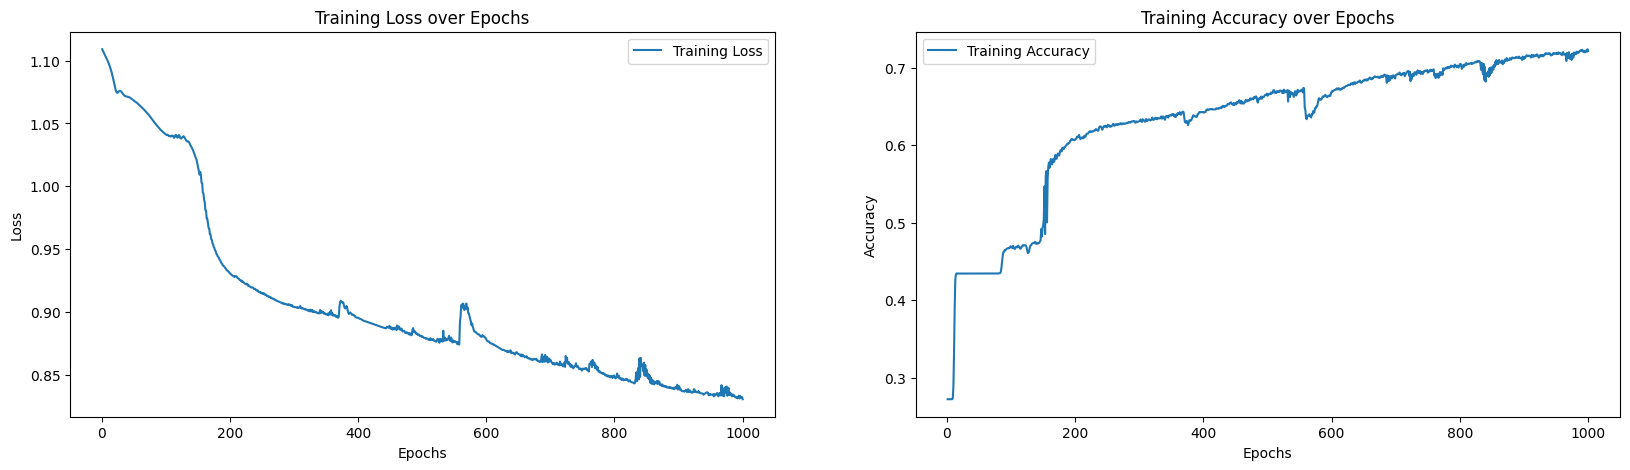

In [ ]:
import matplotlib.pyplot as plt

# Plot loss and accuracy against epoch side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot accuracy
axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].legend()

plt.show()


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_w2v_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_skipgram = np.zeros_like(output_test)
predicted_w2v_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_w2v_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)


Number of correct answers: 573
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 103                 77                  65
True Neutral                   52                315                  26
True Negative                  49                 59                 155
Accuracy: 63.60%
Classification Report:
              precision    recall  f1-score   support

    positive       0.50      0.42      0.46       245
     neutral       0.70      0.80      0.75       393
    negative       0.63      0.59      0.61       263

   micro avg       0.64      0.64      0.64       901
   macro avg       0.61      0.60      0.60       901
weighted avg       0.63      0.64      0.63       901
 samples avg       0.64      0.64      0.64       901



### FastText Cbow-Input

In [ ]:
# Training loop - final_train_ft_cbow
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_ft_cbow)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0924
Epoch [101/1000], Loss: 0.9776
Epoch [201/1000], Loss: 0.9511
Epoch [301/1000], Loss: 0.9395
Epoch [401/1000], Loss: 0.9241
Epoch [501/1000], Loss: 0.9094
Epoch [601/1000], Loss: 0.8995
Epoch [701/1000], Loss: 0.8955
Epoch [801/1000], Loss: 0.8889
Epoch [901/1000], Loss: 0.8836


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_ft_cbow)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_ft_cb = np.zeros_like(output_test)
predicted_ft_cb[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_ft_cb == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_cb.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_cb, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_ft_cb = num_correct / label_test_torch.numpy().shape[0]
accuracy_ft_cb_percentage = accuracy_ft_cb * 100

print(f"Accuracy: {accuracy_ft_cb_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_ft_cb, target_names=class_names)
print("Classification Report:")
print(cr)

Number of correct answers: 542
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  96                 80                  69
True Neutral                   56                308                  29
True Negative                  54                 71                 138
Accuracy: 60.16%
Classification Report:
              precision    recall  f1-score   support

    positive       0.47      0.39      0.43       245
     neutral       0.67      0.78      0.72       393
    negative       0.58      0.52      0.55       263

   micro avg       0.60      0.60      0.60       901
   macro avg       0.57      0.57      0.57       901
weighted avg       0.59      0.60      0.59       901
 samples avg       0.60      0.60      0.60       901



### FastText Skipgram-Input

In [ ]:
# Training loop - final_train_ft_skipgram
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_ft_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.2164
Epoch [101/1000], Loss: 0.9287
Epoch [201/1000], Loss: 0.9130
Epoch [301/1000], Loss: 0.9007
Epoch [401/1000], Loss: 0.8898
Epoch [501/1000], Loss: 0.8799
Epoch [601/1000], Loss: 0.8668
Epoch [701/1000], Loss: 0.8565
Epoch [801/1000], Loss: 0.8522
Epoch [901/1000], Loss: 0.8449


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_ft_skipgram)
output_test = output_test.detach().numpy()

print(output_test.shape)

max_indices = np.argmax(output_test, axis=1)
predicted_ft_skipgram = np.zeros_like(output_test)
predicted_ft_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_ft_skipgram == label_test_torch.numpy(), axis=1))


print(label_test_torch.numpy().shape)

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_ft_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_ft_skipgram_percentage = accuracy_ft_skipgram * 100

print(f"Accuracy: {accuracy_ft_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_ft_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)

(901, 3)
(901, 3)
Number of correct answers: 562
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  94                 76                  75
True Neutral                   50                316                  27
True Negative                  48                 63                 152
Accuracy: 62.38%
Classification Report:
              precision    recall  f1-score   support

    positive       0.49      0.38      0.43       245
     neutral       0.69      0.80      0.75       393
    negative       0.60      0.58      0.59       263

   micro avg       0.62      0.62      0.62       901
   macro avg       0.59      0.59      0.59       901
weighted avg       0.61      0.62      0.61       901
 samples avg       0.62      0.62      0.62       901



## RNN model for ablation study

After choosing the best ebedding input with AT-LSTM. We will compare that model with AT-RNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## output_size : 3

        super(RNNWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_seq):
        # input_seq = ([7978, 41, 50])
        rnn_out, hidden = self.rnn(input_seq)  # rnn_out shape: [7978, 41, 50]
        hidden = hidden.squeeze(0)  # hidden shape: [7978, 50]

        # Compute attention weights
        attention_weights = torch.bmm(rnn_out, hidden.unsqueeze(2)).squeeze(2)  # shape: [7978, 41]
        attention_weights = F.softmax(attention_weights, dim=1)  # shape: [7978, 41]

        # Apply attention weights
        result_self_attention = torch.bmm(rnn_out.transpose(1, 2), attention_weights.unsqueeze(2)).squeeze(2)  # shape: [7978, 50]

        # Fully connected layer
        fc1_out = self.fc1(result_self_attention)  # shape: [7978, 3]
        output = self.softmax(fc1_out)  # shape: [7978, 3]

        return output, attention_weights


In [ ]:
# Initialize the model
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
#number_padding = final_test_w2v_cbow.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = RNNWithAttention(embedding_size, hidden_size, output_size)

# Define loss function and optimizer - adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
# Training loop - final_train_w2v_skipgram
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_w2v_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.1030
Epoch [101/1000], Loss: 0.9705
Epoch [201/1000], Loss: 0.9144
Epoch [301/1000], Loss: 0.9005
Epoch [401/1000], Loss: 0.8932
Epoch [501/1000], Loss: 0.8889
Epoch [601/1000], Loss: 0.8853
Epoch [701/1000], Loss: 0.8844
Epoch [801/1000], Loss: 0.8806
Epoch [901/1000], Loss: 0.8785


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_w2v_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_skipgram = np.zeros_like(output_test)
predicted_w2v_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_w2v_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)


Number of correct answers: 564
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  92                 72                  81
True Neutral                   45                318                  30
True Negative                  45                 64                 154
Accuracy: 62.60%
Classification Report:
              precision    recall  f1-score   support

    positive       0.51      0.38      0.43       245
     neutral       0.70      0.81      0.75       393
    negative       0.58      0.59      0.58       263

   micro avg       0.63      0.63      0.63       901
   macro avg       0.60      0.59      0.59       901
weighted avg       0.61      0.63      0.61       901
 samples avg       0.63      0.63      0.63       901



## GRU model for ablation study

In [ ]:
class GRUWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## output_size : 3

        super(GRUWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_seq):
        ## input_seq = ([7978, 41, 50])
        input_seq = input_seq.permute(1, 0, 2)  ## permute it first to ([41, 7978, 50])
        gru_out, hidden = self.gru(input_seq)  # gru_out shape: [seq_length, batch_size, hidden_size]
        gru_out = gru_out.permute(1, 0, 2)  ## change it back to ([7978, 41, 50])
        hidden = hidden.squeeze(0)  ## now the size is ([7978, 50])

        ## calculate attention weights
        attention_weights = torch.bmm(gru_out, hidden.unsqueeze(2)).squeeze(2)  ## ([7978, 41])
        attention_weights = F.softmax(attention_weights, dim=1)  ## make it a probability distribution

        ## calculate the weighted sum of gru_out
        result_self_attention = torch.bmm(gru_out.transpose(1, 2), attention_weights.unsqueeze(2)).squeeze(2)

        ## add a fully connected layer
        fc1_out = self.fc1(result_self_attention)

        ## apply softmax for class probability
        output = self.softmax(fc1_out)

        return output, attention_weights

In [ ]:
# Initialize the model
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
#number_padding = final_test_w2v_cbow.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = GRUWithAttention(embedding_size, hidden_size, output_size)


# Define loss function and optimizer - adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop - final_train_w2v_skipgram
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_w2v_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.1013
Epoch [101/1000], Loss: 1.0330
Epoch [201/1000], Loss: 0.9737
Epoch [301/1000], Loss: 0.9600
Epoch [401/1000], Loss: 0.9206
Epoch [501/1000], Loss: 0.9104
Epoch [601/1000], Loss: 0.9065
Epoch [701/1000], Loss: 0.9012
Epoch [801/1000], Loss: 0.8977
Epoch [901/1000], Loss: 0.8895


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_w2v_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_skipgram = np.zeros_like(output_test)
predicted_w2v_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_w2v_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)

Number of correct answers: 562
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 105                 61                  79
True Neutral                   53                308                  32
True Negative                  53                 61                 149
Accuracy: 62.38%
Classification Report:
              precision    recall  f1-score   support

    positive       0.50      0.43      0.46       245
     neutral       0.72      0.78      0.75       393
    negative       0.57      0.57      0.57       263

   micro avg       0.62      0.62      0.62       901
   macro avg       0.60      0.59      0.59       901
weighted avg       0.62      0.62      0.62       901
 samples avg       0.62      0.62      0.62       901



# Model 3 - LSTM with Double Attention

In [ ]:
class LSTMWithDAttention(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size2, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## output_size : 3

        super(LSTMWithDAttention, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

        self.key = nn.Linear(hidden_size, hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)


    def forward(self, input_seq):
        ## use all inputs information (both reviews)
        ## input_seq = ([7978, 41, 50])
        x = input_seq[:, :-1, :]
        x = x.permute(1, 0, 2)  ## permute it first to ([40, 7978, 50]) since we want to take all 7978 hidden layers
        lstm_out,(hidden, cell) = self.lstm(x)  # lstm_out shape: [batch_size, seq_length, hidden_size]
        ## now the hidden will have Size([1, 7978, 50])
        lstm_out = lstm_out.permute(1, 0, 2) ## change it back to how it supposed to be ([7978, 40, 50])

        hidden = hidden.squeeze(0) ## now the size is ([7978, 50])

        ## do weighted sum lsmt_out([7978, 41, 50]) * hidden ([7978, 50, 1])
        ## the result will be ([7978, 41]) >> 7978 inputs where each input has 41 words
        attention_weights = torch.bmm(lstm_out, hidden.unsqueeze(2)).squeeze(2) ## calculate the attention of for all inputs

        ## use softmax to make all the 41 words weight bcm probability
        attention_weights = F.softmax(attention_weights, dim=1)

        ## calculate the lstm_output itself with the attention probability
        result_self_attention = torch.bmm(lstm_out.transpose(1, 2),
                                     attention_weights.unsqueeze(2)).squeeze(2)

        ## Second attention with aspect concatenation

        concat_aspect = torch.cat((result_self_attention.unsqueeze(1), input_seq[:,-1:,:]), dim=1)
        fc1_out = self.fc1(concat_aspect.squeeze(0))
        keys = self.key(fc1_out)
        queries = self.query(fc1_out)
        values = self.value(fc1_out)
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float32))

        attention_weights2 = F.softmax(scores, dim=-1)

        # Apply softmax for class probability
        result_second_attention = torch.matmul(attention_weights2, values)

        output = result_second_attention.squeeze(0)

        output = self.fc2(output.view(output.size(0), -1))
        output = self.softmax(output)
        return output, attention_weights


In [ ]:
# Initialize the model
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
hidden_size2 = 100
#number_padding = final_test_w2v_cbow.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = LSTMWithDAttention(embedding_size, hidden_size,hidden_size2, output_size)


# Define loss function and optimizer - adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Glove-Input

In [ ]:
# Training loop - final_train_glove
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_glove)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0941
Epoch [101/1000], Loss: 0.9033
Epoch [201/1000], Loss: 0.8607
Epoch [301/1000], Loss: 0.8377
Epoch [401/1000], Loss: 0.8263
Epoch [501/1000], Loss: 0.8174
Epoch [601/1000], Loss: 0.8114
Epoch [701/1000], Loss: 0.8102
Epoch [801/1000], Loss: 0.8027
Epoch [901/1000], Loss: 0.8005


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_glove)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_glove = np.zeros_like(output_test)
predicted_glove[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_glove == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_glove.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_glove, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_glove= num_correct / label_test_torch.numpy().shape[0]
accuracy_glove_percentage = accuracy_glove * 100

print(f"Accuracy: {accuracy_glove_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_glove, target_names=class_names)
print("Classification Report:")
print(cr)

Number of correct answers: 554
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 111                 70                  64
True Neutral                   61                293                  39
True Negative                  54                 59                 150
Accuracy: 61.49%
Classification Report:
              precision    recall  f1-score   support

    positive       0.49      0.45      0.47       245
     neutral       0.69      0.75      0.72       393
    negative       0.59      0.57      0.58       263

   micro avg       0.61      0.61      0.61       901
   macro avg       0.59      0.59      0.59       901
weighted avg       0.61      0.61      0.61       901
 samples avg       0.61      0.61      0.61       901



## Word2Vec Cbow-Input

In [ ]:
# Training loop - final_train_w2v_cbow
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_w2v_cbow)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.2679
Epoch [101/1000], Loss: 1.0860
Epoch [201/1000], Loss: 1.0178
Epoch [301/1000], Loss: 1.0137
Epoch [401/1000], Loss: 1.0092
Epoch [501/1000], Loss: 1.0065
Epoch [601/1000], Loss: 1.0145
Epoch [701/1000], Loss: 1.0035
Epoch [801/1000], Loss: 1.0032
Epoch [901/1000], Loss: 1.0013


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_w2v_cbow)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_cbow = np.zeros_like(output_test)
predicted_w2v_cbow[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_cbow == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_cbow.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_cbow, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_cbow = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_cbow_percentage = accuracy_w2v_cbow * 100

print(f"Accuracy: {accuracy_w2v_cbow_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_cbow, target_names=class_names)
print("Classification Report:")
print(cr)



Number of correct answers: 496
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 160                 85                   0
True Neutral                   57                336                   0
True Negative                 173                 90                   0
Accuracy: 55.05%
Classification Report:
              precision    recall  f1-score   support

    positive       0.41      0.65      0.50       245
     neutral       0.66      0.85      0.74       393
    negative       0.00      0.00      0.00       263

   micro avg       0.55      0.55      0.55       901
   macro avg       0.36      0.50      0.42       901
weighted avg       0.40      0.55      0.46       901
 samples avg       0.55      0.55      0.55       901



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Word2Vec Skipgram-Input

In [ ]:
# Training loop - final_train_w2v_skipgram
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_w2v_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0836
Epoch [101/1000], Loss: 1.0020
Epoch [201/1000], Loss: 0.9238
Epoch [301/1000], Loss: 0.9188
Epoch [401/1000], Loss: 0.9138
Epoch [501/1000], Loss: 0.9085
Epoch [601/1000], Loss: 0.9058
Epoch [701/1000], Loss: 0.8948
Epoch [801/1000], Loss: 0.8905
Epoch [901/1000], Loss: 0.8852


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_w2v_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_w2v_skipgram = np.zeros_like(output_test)
predicted_w2v_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_w2v_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_w2v_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_w2v_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_w2v_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_w2v_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_w2v_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_w2v_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)


Number of correct answers: 555
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 120                 80                  45
True Neutral                   52                326                  15
True Negative                  70                 84                 109
Accuracy: 61.60%
Classification Report:
              precision    recall  f1-score   support

    positive       0.50      0.49      0.49       245
     neutral       0.67      0.83      0.74       393
    negative       0.64      0.41      0.50       263

   micro avg       0.62      0.62      0.62       901
   macro avg       0.60      0.58      0.58       901
weighted avg       0.61      0.62      0.60       901
 samples avg       0.62      0.62      0.62       901



## FastText Cbow-Input

In [ ]:
# Training loop - final_train_ft_cbow
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_ft_cbow)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.2472
Epoch [101/1000], Loss: 1.0044
Epoch [201/1000], Loss: 1.0044
Epoch [301/1000], Loss: 1.0043
Epoch [401/1000], Loss: 1.0043
Epoch [501/1000], Loss: 1.0043
Epoch [601/1000], Loss: 1.0043
Epoch [701/1000], Loss: 1.0043
Epoch [801/1000], Loss: 1.0043
Epoch [901/1000], Loss: 1.0043


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_ft_cbow)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_ft_cb = np.zeros_like(output_test)
predicted_ft_cb[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_ft_cb == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_cb.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_cb, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_ft_cb = num_correct / label_test_torch.numpy().shape[0]
accuracy_ft_cb_percentage = accuracy_ft_cb * 100

print(f"Accuracy: {accuracy_ft_cb_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_ft_cb, target_names=class_names)
print("Classification Report:")
print(cr)

Number of correct answers: 496
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                   0                199                  46
True Neutral                    0                383                  10
True Negative                   0                150                 113
Accuracy: 55.05%
Classification Report:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00       245
     neutral       0.52      0.97      0.68       393
    negative       0.67      0.43      0.52       263

   micro avg       0.55      0.55      0.55       901
   macro avg       0.40      0.47      0.40       901
weighted avg       0.42      0.55      0.45       901
 samples avg       0.55      0.55      0.55       901



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## FastText Skipgram-Input

In [ ]:
# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

# Training loop - final_train_ft_skipgram
for epoch in range(1000):  # Training for 1000 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output, weight = model(final_train_ft_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        train_output, _ = model(final_train_ft_skipgram)

        # Assuming train_output is logits, get predictions
        train_predictions = torch.argmax(train_output, dim=1)

        # Convert one-hot encoded labels to class indices
        label_indices = torch.argmax(label_train_torch, dim=1)
        train_accuracy = (train_predictions == label_indices).float().mean().item()
        train_accuracies.append(train_accuracy)

    # Store loss
    train_losses.append(loss.item())

    # Print loss and accuracy
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {:.4f}'.format(epoch + 1, 1000, loss.item(), train_accuracy))



Epoch [1/1000], Loss: 1.1015, Training Accuracy: 0.2720
Epoch [101/1000], Loss: 0.9279, Training Accuracy: 0.6057
Epoch [201/1000], Loss: 0.9060, Training Accuracy: 0.6373
Epoch [301/1000], Loss: 0.8982, Training Accuracy: 0.6430
Epoch [401/1000], Loss: 0.8941, Training Accuracy: 0.6463
Epoch [501/1000], Loss: 0.8892, Training Accuracy: 0.6587
Epoch [601/1000], Loss: 0.8838, Training Accuracy: 0.6652
Epoch [701/1000], Loss: 0.8765, Training Accuracy: 0.6470
Epoch [801/1000], Loss: 0.8711, Training Accuracy: 0.6760
Epoch [901/1000], Loss: 0.8658, Training Accuracy: 0.6838


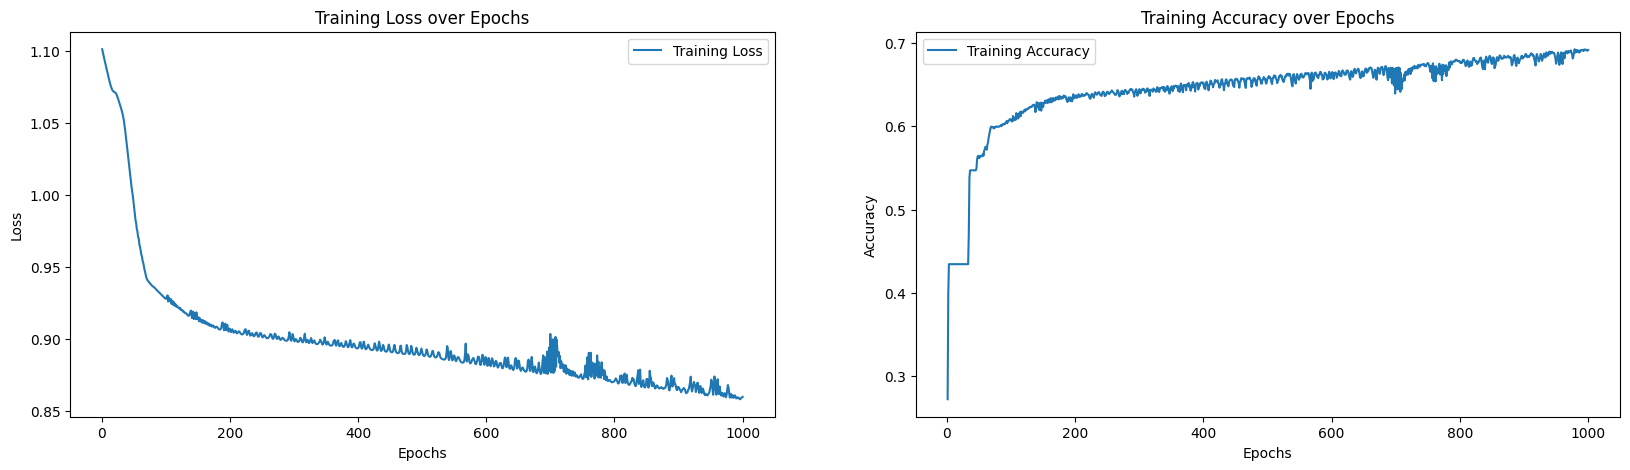

In [ ]:
import matplotlib.pyplot as plt

# Plot loss and accuracy against epoch side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot accuracy
axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].legend()

plt.show()

In [ ]:
# Testing loop
output_test,weight_test = model(final_test_ft_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_ft_cb = np.zeros_like(output_test)
predicted_ft_cb[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_ft_cb == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_cb.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_cb, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_ft_cb = num_correct / label_test_torch.numpy().shape[0]
accuracy_ft_cb_percentage = accuracy_ft_cb * 100

print(f"Accuracy: {accuracy_ft_cb_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_ft_cb, target_names=class_names)
print("Classification Report:")
print(cr)

Number of correct answers: 566
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 101                 71                  73
True Neutral                   52                321                  20
True Negative                  47                 72                 144
Accuracy: 62.82%
Classification Report:
              precision    recall  f1-score   support

    positive       0.51      0.41      0.45       245
     neutral       0.69      0.82      0.75       393
    negative       0.61      0.55      0.58       263

   micro avg       0.63      0.63      0.63       901
   macro avg       0.60      0.59      0.59       901
weighted avg       0.62      0.63      0.62       901
 samples avg       0.63      0.63      0.63       901



## RNN model for ablation study

In [ ]:
class RNNWithDAttention(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size2, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## output_size : 3

        super(RNNWithDAttention, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

        self.key = nn.Linear(hidden_size, hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)


    def forward(self, input_seq):
        # Split input_seq into reviews and aspect parts
        x = input_seq[:, :-1, :]  # reviews
        aspect = input_seq[:, -1, :]  # aspect

        rnn_out, hidden = self.rnn(x)  # rnn_out shape: [batch_size, seq_length, hidden_size]

        hidden = hidden.squeeze(0)  # hidden shape: [batch_size, hidden_size]

        # Attention mechanism
        attention_weights = torch.bmm(rnn_out, hidden.unsqueeze(2)).squeeze(2)  # shape: [batch_size, seq_length]
        attention_weights = F.softmax(attention_weights, dim=1)  # shape: [batch_size, seq_length]

        # Apply attention weights
        result_self_attention = torch.bmm(rnn_out.transpose(1, 2), attention_weights.unsqueeze(2)).squeeze(2)  # shape: [batch_size, hidden_size]

        # Second attention with aspect concatenation
        concat_aspect = torch.cat((result_self_attention.unsqueeze(1), aspect.unsqueeze(1)), dim=1)  # shape: [batch_size, 2, hidden_size]
        fc1_out = self.fc1(concat_aspect)

        keys = self.key(fc1_out)
        queries = self.query(fc1_out)
        values = self.value(fc1_out)
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float32))

        attention_weights2 = F.softmax(scores, dim=-1)

        # Apply the second set of attention weights
        result_second_attention = torch.matmul(attention_weights2, values)

        output = result_second_attention.squeeze(0)

        output = self.fc2(output.view(output.size(0), -1))
        output = self.softmax(output)

        return output, attention_weights



In [ ]:
# Initialize the model
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
hidden_size2 = 100
#number_padding = final_test_w2v_cbow.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = RNNWithDAttention(embedding_size, hidden_size,hidden_size2, output_size)


# Define loss function and optimizer - adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop - fastText sk
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_ft_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0955
Epoch [101/1000], Loss: 0.9310
Epoch [201/1000], Loss: 0.9207
Epoch [301/1000], Loss: 0.9090
Epoch [401/1000], Loss: 0.9048
Epoch [501/1000], Loss: 0.8961
Epoch [601/1000], Loss: 0.8906
Epoch [701/1000], Loss: 0.8877
Epoch [801/1000], Loss: 0.8840
Epoch [901/1000], Loss: 0.8803


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_ft_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_ft_skipgram = np.zeros_like(output_test)
predicted_ft_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_ft_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_ft_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_ft_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_ft_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_ft_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)

Number of correct answers: 547
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                 103                 75                  67
True Neutral                   63                301                  29
True Negative                  54                 66                 143
Accuracy: 60.71%
Classification Report:
              precision    recall  f1-score   support

    positive       0.47      0.42      0.44       245
     neutral       0.68      0.77      0.72       393
    negative       0.60      0.54      0.57       263

   micro avg       0.61      0.61      0.61       901
   macro avg       0.58      0.58      0.58       901
weighted avg       0.60      0.61      0.60       901
 samples avg       0.61      0.61      0.61       901



## GRU model ablation study

In [ ]:
class GRUWithDAttention(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size2, output_size):
        ## input_size : ([7978, 41, 50])
        ## hidden_size : 50
        ## output_size : 3

        super(GRUWithDAttention, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

        self.key = nn.Linear(hidden_size, hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)


    def forward(self, input_seq):
        # Split input_seq into reviews and aspect parts
        x = input_seq[:, :-1, :]  # reviews
        aspect = input_seq[:, -1, :]  # aspect

        gru_out, hidden = self.gru(x)  # rnn_out shape: [batch_size, seq_length, hidden_size]

        hidden = hidden.squeeze(0)  # hidden shape: [batch_size, hidden_size]

        # Attention mechanism
        attention_weights = torch.bmm(gru_out, hidden.unsqueeze(2)).squeeze(2)  # shape: [batch_size, seq_length]
        attention_weights = F.softmax(attention_weights, dim=1)  # shape: [batch_size, seq_length]

        # Apply attention weights
        result_self_attention = torch.bmm(gru_out.transpose(1, 2), attention_weights.unsqueeze(2)).squeeze(2)  # shape: [batch_size, hidden_size]

        # Second attention with aspect concatenation
        concat_aspect = torch.cat((result_self_attention.unsqueeze(1), aspect.unsqueeze(1)), dim=1)  # shape: [batch_size, 2, hidden_size]
        fc1_out = self.fc1(concat_aspect)

        keys = self.key(fc1_out)
        queries = self.query(fc1_out)
        values = self.value(fc1_out)
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float32))

        attention_weights2 = F.softmax(scores, dim=-1)

        # Apply the second set of attention weights
        result_second_attention = torch.matmul(attention_weights2, values)

        output = result_second_attention.squeeze(0)

        output = self.fc2(output.view(output.size(0), -1))
        output = self.softmax(output)

        return output, attention_weights



In [ ]:
# Initialize the model
embedding_size = len(next(iter(embeddings_index)))
hidden_size = 50
hidden_size2 = 100
#number_padding = final_test_w2v_cbow.size(1) ## you can use any since all input are same size
output_size = label_train_torch.size(-1)

# Initialize the model
model = GRUWithDAttention(embedding_size, hidden_size,hidden_size2, output_size)


# Define loss function and optimizer - adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop - fastText sk
for epoch in range(1000):  # Training for 100 epochs
    model.train()  # Set the model to training mode

    optimizer.zero_grad()
    output,weight = model(final_train_ft_skipgram)  # Forward pass

    # Calculate loss with attention
    loss = criterion(output, label_train_torch)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [1/1000], Loss: 1.0967
Epoch [101/1000], Loss: 0.9199
Epoch [201/1000], Loss: 0.8968
Epoch [301/1000], Loss: 0.8856
Epoch [401/1000], Loss: 0.8754
Epoch [501/1000], Loss: 0.8690
Epoch [601/1000], Loss: 0.8617
Epoch [701/1000], Loss: 0.8570
Epoch [801/1000], Loss: 0.8530
Epoch [901/1000], Loss: 0.8489


In [ ]:
# Testing loop
output_test,weight_test = model(final_test_ft_skipgram)
output_test = output_test.detach().numpy()

max_indices = np.argmax(output_test, axis=1)
predicted_ft_skipgram = np.zeros_like(output_test)
predicted_ft_skipgram[np.arange(len(output_test)), max_indices] = 1

num_correct = np.sum(np.all(predicted_ft_skipgram == label_test_torch.numpy(), axis=1))

print("Number of correct answers:", num_correct)

# Compute confusion matrix
conf_matrix = np.zeros((predicted_ft_skipgram.shape[1], label_test_torch.numpy().shape[1]), dtype=int)
for pred, true in zip(predicted_ft_skipgram, label_test_torch.numpy()):
    pred_idx = np.where(pred == 1)[0]
    true_idx = np.where(true == 1)[0]
    conf_matrix[true_idx[:, None], pred_idx] += 1

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Neutral', 'True Negative'],
                              columns=['Predicted Positive', 'Predicted Neutral', 'Predicted Negative'])

print("Confusion matrix:")
print(conf_matrix_df)

accuracy_ft_skipgram = num_correct / label_test_torch.numpy().shape[0]
accuracy_ft_skipgram_percentage = accuracy_w2v_skipgram * 100

print(f"Accuracy: {accuracy_ft_skipgram_percentage:.2f}%")

# Classification report
class_names = ["positive", "neutral", "negative"]
cr = classification_report(label_test_torch.numpy(), predicted_ft_skipgram, target_names=class_names)
print("Classification Report:")
print(cr)

Number of correct answers: 586
Confusion matrix:
               Predicted Positive  Predicted Neutral  Predicted Negative
True Positive                  94                 65                  86
True Neutral                   33                326                  34
True Negative                  35                 62                 166
Accuracy: 60.71%
Classification Report:
              precision    recall  f1-score   support

    positive       0.58      0.38      0.46       245
     neutral       0.72      0.83      0.77       393
    negative       0.58      0.63      0.60       263

   micro avg       0.65      0.65      0.65       901
   macro avg       0.63      0.61      0.61       901
weighted avg       0.64      0.65      0.64       901
 samples avg       0.65      0.65      0.65       901



# Visualize

### Sample 1

In [ ]:
output_test,weight_test = model(final_test_w2v_skipgram) # the best model
weight_test = weight_test.detach().numpy()

In [ ]:
test_aspects[568]

'staff'

In [ ]:
test_reviews[568]

['food',
 'little',
 'difilculty',
 'keeping',
 'orders',
 'straight',
 'menu',
 'many',
 'choicesbut',
 'server',
 'helpul',
 'suggested',
 'de',
 'paella',
 'valenciana',
 'extremele',
 'delicious']

In [ ]:
len(test_reviews[568])

17

In [ ]:
test_label[568]

'positive'

In [ ]:
weight_test[568][:17]

array([1.45808357e-07, 1.18855034e-07, 3.92959777e-07, 9.71736426e-07,
       1.23186537e-05, 2.24784508e-05, 1.17749396e-05, 9.21095761e-06,
       9.08486072e-06, 3.09362367e-05, 2.91735669e-05, 3.26863083e-05,
       2.47188927e-05, 2.57164284e-05, 2.91509277e-05, 3.70617563e-05,
       3.12992051e-05], dtype=float32)

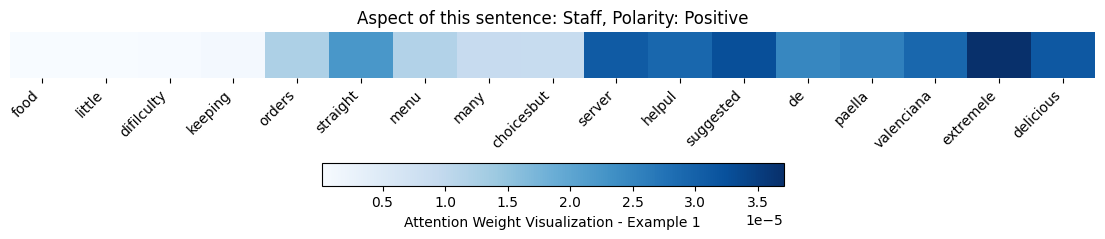

In [ ]:
data_reshaped = weight_test[568][:17].reshape(1, -1)


# Create the figure and the main axis
fig, ax = plt.subplots(figsize=(14, 2))

# Create the heatmap with a single color and varying lightness
heatmap = sns.heatmap(data_reshaped, cmap='Blues', cbar=False, xticklabels=test_reviews[568])

# Add color bar
cbar = fig.colorbar(heatmap.get_children()[0], orientation="horizontal", pad=0.55)  # Adjust pad for spacing
cbar.set_label('Attention Weight Visualization - Example 1')

# Customize the plot
ax.set_title('Aspect of this sentence: Staff, Polarity: Positive')
ax.set_yticks([])  # Hide the y-axis ticks
ax.set_xticklabels(test_reviews[568], rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.show()




### Sample 2

In [ ]:
test_aspects[305]

'service'

In [ ]:
test_reviews[305]

['tried', 'get', 'table', 'restaurant', 'week', 'hour', 'wait']

In [ ]:
len(test_reviews[305])

7

In [ ]:
test_label[305]

'negative'

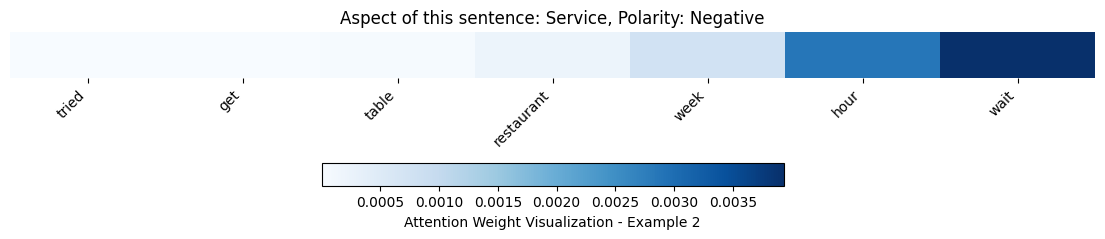

In [ ]:
data_reshaped = weight_test[305][:7].reshape(1, -1)


# Create the figure and the main axis
fig, ax = plt.subplots(figsize=(14, 2))

# Create the heatmap with a single color and varying lightness
heatmap = sns.heatmap(data_reshaped, cmap='Blues', cbar=False, xticklabels=test_reviews[305])

# Add color bar
cbar = fig.colorbar(heatmap.get_children()[0], orientation="horizontal", pad=0.55)  # Adjust pad for spacing
cbar.set_label('Attention Weight Visualization - Example 2')

# Customize the plot
ax.set_title('Aspect of this sentence: Service, Polarity: Negative')
ax.set_yticks([])  # Hide the y-axis ticks
ax.set_xticklabels(test_reviews[305], rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.show()
